# Introduction

Proteins, as one of the basic building blocks and functional units of human cells, serve crucial roles in cell operations. The analysis of proteome, or an entire set of human protein expressed by genomes, cells, or organelles, can be conducted using images taken by microscopy technologies. In particular, the localizations of proteins in specific cell organelles can provide key information for human proteome study.

With the advance of deep learning in recent years, the classification of proteins, or biological imaging data in general, which is usually accomplished by skilled biologists, can be assisted or even automated using advanced technologies of Computer Vision and Neural Nets.

In modern studies, protein datasets can be analyzed and classified when the amio acid sequence data is recorded. With the sequential data for each protein converted to numeric data, a Recurrent Neural Network (RNN) such as LSTM model can be applied to categorize the class of the protein. On the contrary, proteins can also be observed and imaged using microscopy approaches, and the images can be classified by Convolutional Neural Networks (CNNs).

The [Human Protein Atlas](https://www.proteinatlas.org/) is a Swedish program aimming at mapping all human proteins, and  one of the approaches used is imaging cell and cell organelles using confocal microscopy. Subcellular protein locatizations in cell organelles can thus be clearly reflected in the fluorescence microscopy images. In this project, a dataset of more than 124,000 such microscopy images from the Human Protein Atlas is used to train a CNN image classification model. In the dataset, there are 28 types of cell organelles including Nucleoplasm, Nucleoli, Nuclear speckles, Golgi apparatus, Endoplasmic reticulum, Peroxisomes, Endosomes, Lysomes, Lipids, Mitochondria, Filaments, etc. indicated with label number from 0-27. The trained CNN model, fed with an image input, would perform a multi-label classification task to predict a list of labels indicating the subcellular organelles in which protein localizes. It is worth mentioning that, as explained in the study *Analysis of the Human Protein Atlas Image Classification competition* ([DOI: 10.1038/s41592-019-0658-6](https://www.nature.com/articles/s41592-019-0658-6.epdf?shared_access_token=1f-vE5M2Nbk9yIytlGzhhNRgN0jAjWel9jnR3ZoTv0M3bV4dn-yP-0ZVNmntgbt1B9dnxVNJFA4G95nRwc6YQBRkTOvf8Fz2VxeaCCFDBPBltR8NtVFhHq77x45pVP7nlpfdTmnHbp34-WXWxiPb7Q%3D%3D)), the dataset has highly imbalanced classes, so the F1-score is used as the primary metric for the model performance.

In the following, two CNN models are designed, implemented, and trained on Kaggle Notebooks, using a Nvidia Telsa P100 GPU. The two models mainly utilize the pre-trained imagenet model in Keras application library, one being Inception-Resnet-V2 and the other being Vgg-16. The performance of the models is then evaluated, and it is observed that, when all training hyperparameters are identical, the Inception-Resnet-V2 model (with F1-score 0.6379) out-performs the Vgg-16 model (with F1-score 0.5043). Finally, predictions are made on selected data, and it is observed that the Inception-Resnet-V2 model has far more true positives, while the Vgg model has more false positives and negatives.

More information about the dataset can be found [here](https://www.kaggle.com/c/human-protein-atlas-image-classification/data). 

# Data Preprocessing

Import libraries, and load training label dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import os, sys

# image processing and augmentation libraries
import cv2
from PIL import Image
from imgaug import augmenters as iaa

# ML libraries
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
targets = pd.read_csv('./Dataset/train.csv')
targets.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


It can be observed that each row's ID represents a protein image, and the Target shown represents the labels of the organelles that protein localizes. Now, convert the dataframe to a numpy array of Id-integer label pairs.

In [3]:
photoLabels = []
for index, row in targets.iterrows():
    labels = row['Target'].split(' ')
    labels = [int(label) for label in labels]
    photoLabels.append([os.path.join('./Dataset/train', row['Id']),
                       np.array(labels)])
photoLabels = np.array(photoLabels)

Now, construct a training data generator function that generates a batch of training data(images), and its corresponding labels. The function first initializes the batch data structure, then loads and stacks the 4 colour PNG images of the same ID together and processes the image, and finally if required, augments the image by performing rotation/flips. 

In [4]:
def dataGen(photoLabels, batch_size, shape, augment=True):
     while True:
        
        # initialize batch data structure 
        randomIdx = np.random.choice(len(photoLabels), batch_size)
        batchImgs = np.empty((batch_size, shape[0], shape[1], shape[2]))
        batchLabels = np.zeros((batch_size, 28))
        
        for i, idx in enumerate(randomIdx):
            
            # Stacking the various coloured fluorescent images together, and process the image.
            src = photoLabels[idx][0]
            redImg = np.array(Image.open(src + '_red.png'))
            greenImg = np.array(Image.open(src + '_green.png'))
            blueImg = np.array(Image.open(src + '_blue.png'))
            yellowImg = np.array(Image.open(src + '_yellow.png'))
        
            img = np.stack((redImg/2 + yellowImg/2, greenImg/2 + yellowImg/2, blueImg/2), -1)
            img = cv2.resize(img, (shape[0], shape[1]))
            img = np.divide(img, 255)
            
            # Image augementation using imgaug library.
            if augment:
                seq = iaa.Sequential([
                    iaa.OneOf([
                        iaa.Fliplr(),
                        iaa.Flipud(),
                        iaa.Affine(rotate=180),
                        iaa.Affine(rotate=270),
                        iaa.Affine(rotate=90)
                    ])], 
                    random_order=True)               
                img = seq.augment_image(img)
            
            # Turn into one hot-encoded label.
            batchImgs[i] = img
            batchLabels[i][photoLabels[idx][1]] = 1
            
        yield batchImgs, batchLabels

Perform train-test split with 20% validation data.

In [5]:
X_train, y_train, X_test, y_test = train_test_split(targets['Id'], targets['Target'],
                                                    random_state=101, test_size=0.2,
                                                   shuffle=True)

To visualize the input images and more importantly for the sake of the appreciation of the beauty of Biology and Nature, 10 batches (batchsize=5) of images are generated and displayed using the training data generator. Note that the shape of the input data is always set to (299, 299, 3) because this shape will be later required by all Keras pre-trained application models. 

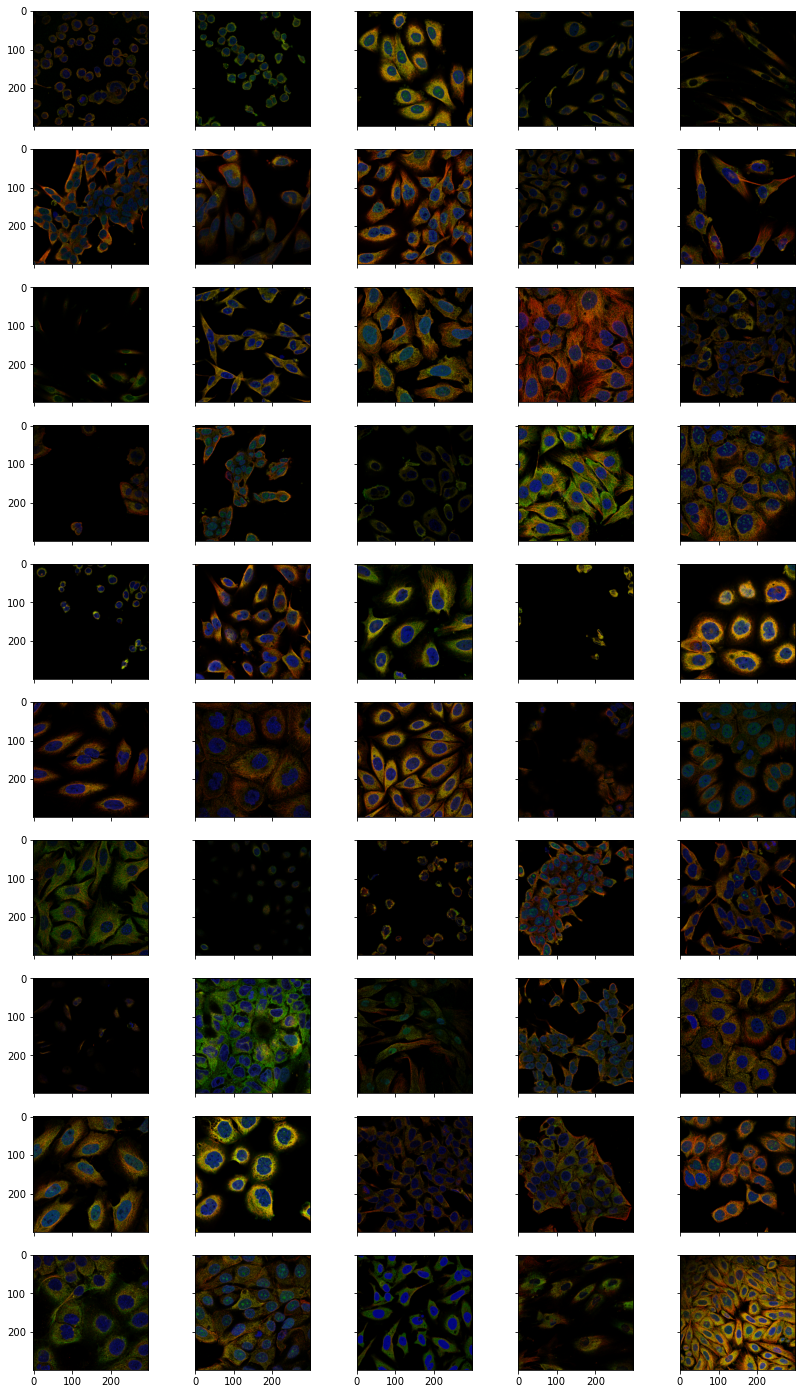

In [6]:
train_data = dataGen(photoLabels, 5, (299, 299, 3), augment=True)

fig, ax = plt.subplots(10, 5, figsize=(14, 25), sharex='col', sharey='row')
for i in range(10):
    for j in range(5):
        imgs, labels = next(train_data)
        ax[i, j].imshow(imgs[j])

Now, define the CNN model utilizing the pre-trained imagenet Inception-ResNet-V2 model from Keras applications. The model consists of an input layer and a batch normalization layer to process the batch data first, then passes the batch into the Inception-ResNet-V2 layer. Then, an extra convolutional layer is added with 128 filters and the regular 3x3 kernel size to learn detailed features. Finally, the data is passed into a dense layer with dropouts and an output layer with sigmoid activation function to indicate the predicted probability of each of the labels.

In [7]:
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout, Activation, BatchNormalization, Input
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

# input layer and batch normalization
inputLayer = Input(shape=(299, 299, 3)) 
ResNetModel = BatchNormalization() (inputLayer)

# pre-trained model from keras applications library
ResNetModel = InceptionResNetV2(weights='imagenet', input_shape=(299, 299, 3), include_top=False)(ResNetModel)

# extra convolutional layer
ResNetModel = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(ResNetModel)

# Flatten and pass into a densely connected layer
ResNetModel = Flatten()(ResNetModel)
ResNetModel = Dropout(0.5)(ResNetModel)

ResNetModel = Dense(512, activation='relu')(ResNetModel)
ResNetModel = Dropout(0.5)(ResNetModel)

# output
ResNetModel = Dense(28, activation='sigmoid')(ResNetModel)
ResNetModel = Model(inputLayer, ResNetModel)

219062272/219055592 [==============================] - 2s 0us/step


Since the dataset provided has very imbalanced classes, accuracy and precision are not appropriate metrics to measure the performance of the model. Instead, since F1-score takes both precision (True Positive/(True Positive + False Positive)) and recall (True Positive/(True Positive + False Negative)) into account, F1-score is thus chosen to be the model performance metric. Due to the fact that in Keras 2, the recall and precision metrics, along with the F1-score metric, is removed, a customized version has to be built using keras backend.

In [8]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Also, define a plt graphing function to display the training history once the training finishes.

In [9]:
def trainHistory(history):
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    
    ax[1].set_title('f1')
    ax[1].plot(history.epoch, history.history["f1"], label="Train f1")
    ax[1].plot(history.epoch, history.history["val_f1"], label="Validation f1")
    
    ax[2].set_title('acc')
    ax[2].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[2].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()

Configure a checkpoint callback with save-best-only setting for efficiency. Then, a training set generator and a validation set generator are defined using the data generating function. Finally, with the checkpoint callback, the model is compiled.

Note that, the Inception-ResNet-V2 layer is set to be not-trainable; the loss of the compiled model is using binary crossentropy (for a multilabel task) instead of the usual categorical crossentropy; the metrics are set to both accuracy and F1-score.

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, LambdaCallback
from keras import metrics
from tensorflow.keras.optimizers import Adam

checkpointCallback = ModelCheckpoint('./checkpoint/HPAImageClassInceptionResNetV2.checkpoint',
                                    verbose=2, save_best_only=True)

trainSetGen = dataGen(photoLabels[X_train.index], 10, (299, 299, 3), augment=False)
validateSetGen = dataGen(photoLabels[X_test.index], 256, (299, 299, 3), augment=False)

ResNetModel.layers[2].trainable = False

ResNetModel.compile(loss='binary_crossentropy', optimizer=Adam(1e-3), metrics=['acc', f1])

Train the Resnet model with just 20 epochs to first monitor the training progress.

In [12]:
ResNetModel.fit_generator(
    generator=trainSetGen,
    steps_per_epoch=100,
    validation_data=next(validateSetGen),
    epochs=20,
    verbose=1,
    callbacks=[checkpointCallback]
)

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.2325 - acc: 0.2760 - f1: 0.1730
Epoch 00001: val_loss improved from inf to 192.02762, saving model to /kaggle/working/checkpoint/HPAImageClassInceptionResNetV2.checkpoint
100/100 [==============================] - 175s 2s/step - loss: 0.2325 - acc: 0.2760 - f1: 0.1730 - val_loss: 192.0276 - val_acc: 0.4531 - val_f1: 0.2576
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.1924 - acc: 0.2870 - f1: 0.1130
Epoch 00002: val_loss improved from 192.02762 to 24.03051, saving model to /kaggle/working/checkpoint/HPAImageClassInceptionResNetV2.checkpoint
100/100 [==============================] - 172s 2s/step - loss: 0.1924 - acc: 0.2870 - f1: 0.1130 - val_loss: 24.0305 - val_acc: 0.4531 - val_f1: 0.2795
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.1894 - acc: 0.3640 - f1: 0.1652
Epoch 00003: val_loss improved from 24.03051 to 0.17809, saving model to /kaggle/working/checkpoin

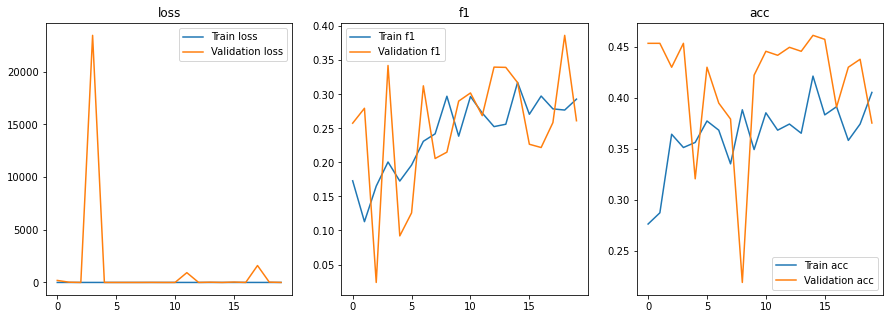

In [13]:
trainHistory(ResNetModel.history)

In [15]:
ResNetModel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 299, 299, 3)       12        
_________________________________________________________________
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
conv2d_204 (Conv2D)          (None, 8, 8, 128)         196736    
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4194

It can be observed that the learning rate of 0.001 is too large. The model as a result shoots over minima when adjusting the weight. Therefore, learning rate is adjusted to $1^{-4}$. With a more reliable learning rate, the Resnet Model is then trained with same hyperparameters, but with 150 epochs on the GPU.

In [16]:
checkpointCallback = ModelCheckpoint('./checkpoint/HPAImageClassInceptionResNetV2.checkpoint',
                                    verbose=2, save_best_only=True)

trainSetGen = dataGen(photoLabels[X_train.index], 10, (299, 299, 3), augment=True)
validateSetGen = dataGen(photoLabels[X_test.index], 256, (299, 299, 3), augment=False)

ResNetModel.layers[2].trainable = True

ResNetModel.compile(loss='binary_crossentropy', optimizer=Adam(1e-4), metrics=['acc', f1])

ResNetModel.fit_generator(generator=trainSetGen,
                        steps_per_epoch=100,
                        validation_data=next(validateSetGen),
                        epochs=150,
                        verbose=1,
                        callbacks=[checkpointCallback])

Epoch 1/150
100/100 [==============================] - 169s 2s/step - loss: 0.2640 - acc: 0.9103 - f1: 0.1803 - val_loss: 0.1908 - val_acc: 0.9406 - val_f1: 0.1700

Epoch 00001: val_loss improved from inf to 0.19079, saving model to /kaggle/working/checkpoint/HPAImageClassInceptionResNetV2-modified2.checkpoint
Epoch 2/150
100/100 [==============================] - 53s 531ms/step - loss: 0.2049 - acc: 0.9363 - f1: 0.2107 - val_loss: 0.1848 - val_acc: 0.9408 - val_f1: 0.0000e+00

Epoch 00002: val_loss improved from 0.19079 to 0.18484, saving model to /kaggle/working/checkpoint/HPAImageClassInceptionResNetV2-modified2.checkpoint
Epoch 3/150
100/100 [==============================] - 52s 523ms/step - loss: 0.2020 - acc: 0.9373 - f1: 0.1438 - val_loss: 0.1933 - val_acc: 0.9418 - val_f1: 0.1431

Epoch 00003: val_loss did not improve from 0.18484
Epoch 4/150
100/100 [==============================] - 52s 523ms/step - loss: 0.1952 - acc: 0.9393 - f1: 0.1762 - val_loss: 0.1783 - val_acc: 0.9427

100/100 [==============================] - 51s 510ms/step - loss: 0.1246 - acc: 0.9577 - f1: 0.5153 - val_loss: 0.1362 - val_acc: 0.9561 - val_f1: 0.4821

Epoch 00065: val_loss did not improve from 0.12492
Epoch 66/150
100/100 [==============================] - 51s 510ms/step - loss: 0.1276 - acc: 0.9564 - f1: 0.5206 - val_loss: 0.1271 - val_acc: 0.9570 - val_f1: 0.5440

Epoch 00066: val_loss did not improve from 0.12492
Epoch 67/150
100/100 [==============================] - 51s 507ms/step - loss: 0.1257 - acc: 0.9585 - f1: 0.5456 - val_loss: 0.1241 - val_acc: 0.9577 - val_f1: 0.5199

Epoch 00067: val_loss improved from 0.12492 to 0.12414, saving model to /kaggle/working/checkpoint/HPAImageClassInceptionResNetV2-modified2.checkpoint
Epoch 68/150
100/100 [==============================] - 50s 503ms/step - loss: 0.1280 - acc: 0.9557 - f1: 0.5005 - val_loss: 0.1262 - val_acc: 0.9561 - val_f1: 0.5232

Epoch 00068: val_loss did not improve from 0.12414
Epoch 69/150
100/100 [===============

100/100 [==============================] - 51s 511ms/step - loss: 0.1133 - acc: 0.9605 - f1: 0.5802 - val_loss: 0.1117 - val_acc: 0.9608 - val_f1: 0.5648

Epoch 00099: val_loss did not improve from 0.10790
Epoch 100/150
100/100 [==============================] - 51s 507ms/step - loss: 0.1130 - acc: 0.9620 - f1: 0.6015 - val_loss: 0.1138 - val_acc: 0.9614 - val_f1: 0.5994

Epoch 00100: val_loss did not improve from 0.10790
Epoch 101/150
100/100 [==============================] - 51s 513ms/step - loss: 0.1110 - acc: 0.9605 - f1: 0.5847 - val_loss: 0.1122 - val_acc: 0.9628 - val_f1: 0.6118

Epoch 00101: val_loss did not improve from 0.10790
Epoch 102/150
100/100 [==============================] - 51s 509ms/step - loss: 0.1134 - acc: 0.9614 - f1: 0.5993 - val_loss: 0.1117 - val_acc: 0.9608 - val_f1: 0.5825

Epoch 00102: val_loss did not improve from 0.10790
Epoch 103/150
100/100 [==============================] - 52s 518ms/step - loss: 0.1142 - acc: 0.9606 - f1: 0.5827 - val_loss: 0.1083 -

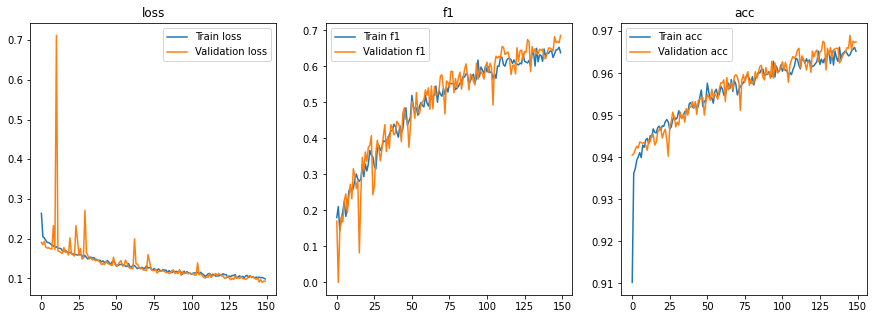

In [54]:
trainHistory(ResNetModel.history)

It can be observed that with a smaller learning rate, the binary crossentropy loss gradually decreases, and that the F1-score and the accuracy of the model predictions keep increasing. Note that both F1-score and accuracy curves are not flattened yet, so the model can still be improved if it is trained with more epochs. For the currently trained ResNet model, its F1-score is around 0.638, and its accuracy is approximately 0.965.

Next, a second model is implemented utilizing the Keras pre-trained Vgg-16 model. Since later its performance is to be compared with that of the ResNet model, its structure and training hyperparameters are set to be identical to that of the ResNet model, with only the Inception-ResNet-V2 pre-trained model layer replaced by Vgg-16. Learning rate is still set to $1^{-4}$; loss is still set to be binary crossentropy; number of epochs is maintained at 150.

In [55]:
from tensorflow.keras.applications import VGG16

# input layer and batch normalization
inputLayer = Input(shape=(299, 299, 3))
vggModel = BatchNormalization()(inputLayer)

# pre-trained model from keras applications library
vggModel = VGG16(weights='imagenet',input_shape=(299, 299, 3), include_top=False)(vggModel)

# extra convolutional layer
vggModel = Conv2D(filters=128, activation='relu', kernel_size=(1, 1))(vggModel)

# Flatten and pass into a densely connected layer
vggModel = Flatten()(vggModel)
vggModel = Dropout(0.5)(vggModel)
vggModel = Dense(512, activation='relu')(vggModel)
vggModel = Dropout(0.5)(vggModel)

# output
vggModel = Dense(28, activation='sigmoid')(vggModel)
vggModel = Model(inputLayer, vggModel)

vggModel.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
batch_normalization_205 (Bat (None, 299, 299, 3)       12        
_________________________________________________________________
vgg16 (Model)                (None, 9, 9, 512)         14714688  
_________________________________________________________________
conv2d_205 (Conv2D)          (None, 9, 9, 128)         65664     
_________________________________________________________________
flatten_2 (Flatten)          (None, 10368)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 10368)             0         
____________________________________________________________

In [56]:
checkpointCallback = ModelCheckpoint('./checkpoint/HPAImageClassVgg.checkpoint',
                                    verbose=2, save_best_only=True)

trainSetGen = dataGen(photoLabels[X_train.index], 10, (299, 299, 3), augment=True)
validateSetGen = dataGen(photoLabels[X_test.index], 256, (299, 299, 3), augment=False)

vggModel.layers[2].trainable = True

vggModel.compile(loss='binary_crossentropy', optimizer=Adam(1e-4), metrics=['acc', f1])

vggModel.fit_generator(generator=trainSetGen,
                        steps_per_epoch=100,
                        validation_data=next(validateSetGen),
                        epochs=150,
                        verbose=1,
                        callbacks=[checkpointCallback])

Epoch 1/150
100/100 [==============================] - 43s 429ms/step - loss: 0.2455 - acc: 0.9198 - f1: 0.1575 - val_loss: 0.1922 - val_acc: 0.9397 - val_f1: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.19215, saving model to /kaggle/working/checkpoint/HPAImageClassInceptionResNetV2-vgg.checkpoint
Epoch 2/150
100/100 [==============================] - 38s 378ms/step - loss: 0.2086 - acc: 0.9357 - f1: 0.1475 - val_loss: 0.1895 - val_acc: 0.9397 - val_f1: 0.0000e+00

Epoch 00002: val_loss improved from 0.19215 to 0.18948, saving model to /kaggle/working/checkpoint/HPAImageClassInceptionResNetV2-vgg.checkpoint
Epoch 3/150
100/100 [==============================] - 39s 387ms/step - loss: 0.2017 - acc: 0.9360 - f1: 0.1601 - val_loss: 0.1828 - val_acc: 0.9397 - val_f1: 0.0000e+00

Epoch 00003: val_loss improved from 0.18948 to 0.18276, saving model to /kaggle/working/checkpoint/HPAImageClassInceptionResNetV2-vgg.checkpoint
Epoch 4/150
100/100 [==============================] - 3


Epoch 00063: val_loss did not improve from 0.15298
Epoch 64/150
100/100 [==============================] - 37s 371ms/step - loss: 0.1544 - acc: 0.9487 - f1: 0.3608 - val_loss: 0.1519 - val_acc: 0.9487 - val_f1: 0.3618

Epoch 00064: val_loss improved from 0.15298 to 0.15193, saving model to /kaggle/working/checkpoint/HPAImageClassInceptionResNetV2-vgg.checkpoint
Epoch 65/150
100/100 [==============================] - 36s 365ms/step - loss: 0.1459 - acc: 0.9513 - f1: 0.4112 - val_loss: 0.1510 - val_acc: 0.9478 - val_f1: 0.3807

Epoch 00065: val_loss improved from 0.15193 to 0.15103, saving model to /kaggle/working/checkpoint/HPAImageClassInceptionResNetV2-vgg.checkpoint
Epoch 66/150
100/100 [==============================] - 38s 376ms/step - loss: 0.1564 - acc: 0.9482 - f1: 0.3768 - val_loss: 0.1504 - val_acc: 0.9477 - val_f1: 0.3613

Epoch 00066: val_loss improved from 0.15103 to 0.15036, saving model to /kaggle/working/checkpoint/HPAImageClassInceptionResNetV2-vgg.checkpoint
Epoch 67/


Epoch 00095: val_loss improved from 0.14042 to 0.13764, saving model to /kaggle/working/checkpoint/HPAImageClassInceptionResNetV2-vgg.checkpoint
Epoch 96/150
100/100 [==============================] - 36s 359ms/step - loss: 0.1381 - acc: 0.9542 - f1: 0.4452 - val_loss: 0.1402 - val_acc: 0.9513 - val_f1: 0.4633

Epoch 00096: val_loss did not improve from 0.13764
Epoch 97/150
100/100 [==============================] - 35s 354ms/step - loss: 0.1383 - acc: 0.9539 - f1: 0.4703 - val_loss: 0.1400 - val_acc: 0.9519 - val_f1: 0.4923

Epoch 00097: val_loss did not improve from 0.13764
Epoch 98/150
100/100 [==============================] - 36s 359ms/step - loss: 0.1389 - acc: 0.9537 - f1: 0.4525 - val_loss: 0.1361 - val_acc: 0.9533 - val_f1: 0.4678

Epoch 00098: val_loss improved from 0.13764 to 0.13610, saving model to /kaggle/working/checkpoint/HPAImageClassInceptionResNetV2-vgg.checkpoint
Epoch 99/150
100/100 [==============================] - 36s 363ms/step - loss: 0.1410 - acc: 0.9537 - f

100/100 [==============================] - 36s 355ms/step - loss: 0.1376 - acc: 0.9536 - f1: 0.4608 - val_loss: 0.1302 - val_acc: 0.9531 - val_f1: 0.4943

Epoch 00130: val_loss improved from 0.13061 to 0.13016, saving model to /kaggle/working/checkpoint/HPAImageClassInceptionResNetV2-vgg.checkpoint
Epoch 131/150
100/100 [==============================] - 37s 374ms/step - loss: 0.1347 - acc: 0.9559 - f1: 0.4990 - val_loss: 0.1350 - val_acc: 0.9549 - val_f1: 0.5301

Epoch 00131: val_loss did not improve from 0.13016
Epoch 132/150
100/100 [==============================] - 36s 357ms/step - loss: 0.1325 - acc: 0.9563 - f1: 0.5062 - val_loss: 0.1273 - val_acc: 0.9561 - val_f1: 0.5403

Epoch 00132: val_loss improved from 0.13016 to 0.12734, saving model to /kaggle/working/checkpoint/HPAImageClassInceptionResNetV2-vgg.checkpoint
Epoch 133/150
100/100 [==============================] - 37s 373ms/step - loss: 0.1309 - acc: 0.9559 - f1: 0.5131 - val_loss: 0.1324 - val_acc: 0.9549 - val_f1: 0.515

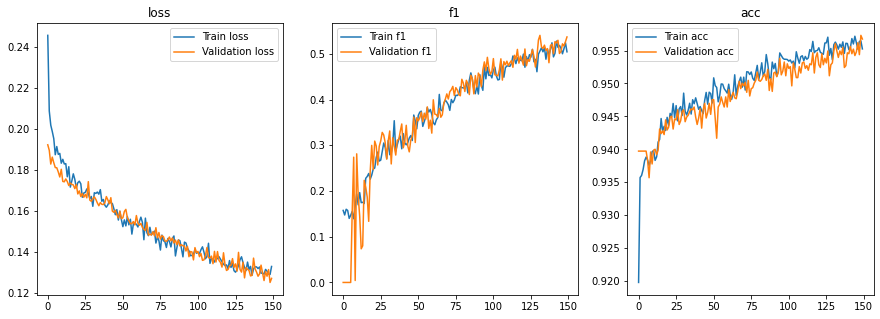

In [66]:
trainHistory(vggModel.history)

For the Vgg model, both F1-score and accuracy curves are not flattened yet, and in fact, they are more sloped then that of the ResNet model, so the model can still be improved considerably if it is trained with more epochs. For the currently trained Vgg model, its F1-score is around 0.504, and its accuracy is approximately 0.955. For future experimentations, the Vgg model can be trained with many more epochs to see if training results will have significant improvement.

A simple comparison between the ResNet model (F1: 0.64, Acc: 0.965) and the Vgg model (F1: 0.50, Acc: 0.955) can conclude that under the same training hyperparameters and neural net design in this project, the ResNet model out-performs the Vgg model. In order to visualize the difference in the models' prediction performances, in the following the first 10 entries from the training dataset is fed into both models, and both prediction results are compared against the true labels. 

In [76]:
for i in range(0, 10):
    
    # Load images
    src = os.path.join(os.path.join("./Dataset/train", targets.iloc[i]['Id']))
    redImg = np.array(Image.open(src + '_red.png'))
    greenImg = np.array(Image.open(src + '_green.png'))
    blueImg = np.array(Image.open(src + '_blue.png'))
    yellowImg = np.array(Image.open(src + '_yellow.png'))
    
    # Stack and preprocess
    img = np.stack((redImg/2 + yellowImg/2, greenImg/2 + yellowImg/2, blueImg/2), -1)
    img = cv2.resize(img, (299, 299))
    img = np.divide(img, 255)
    
    # Make predictions
    predictionResNet = cnnModel2.predict(img[np.newaxis])[0]
    predictionVgg = vggModel.predict(img[np.newaxis])[0]
    predictionResNet = np.arange(28)[predictionResNet >= 0.2]
    predictionVgg = np.arange(28)[predictionVgg >= 0.2]
    
    # Output result
    print('---------------------')
    print('{}th image prediction comparison'.format(i+1))
    print(predictionResNet)
    print(predictionVgg)
    print(targets.iloc[i]['Target'])

---------------------
1th image prediction comparison
[0 2]
[0 7]
16 0
---------------------
2th image prediction comparison
[0 1 2]
[0 2]
7 1 2 0
---------------------
3th image prediction comparison
[ 5 19]
[5]
5
---------------------
4th image prediction comparison
[0 1]
[ 0 25]
1
---------------------
5th image prediction comparison
[18 19]
[3]
18
---------------------
6th image prediction comparison
[ 0 23 25]
[ 0 25]
0
---------------------
7th image prediction comparison
[ 2 21 25]
[ 2 23 25]
25 2
---------------------
8th image prediction comparison
[0]
[ 0 25]
0
---------------------
9th image prediction comparison
[0 2]
[0 2]
2 0
---------------------
10th image prediction comparison
[7]
[ 7 23]
7


It can be observed that the ResNet model has more true positives and negatives than the Vgg model, and that the Vgg model has more false positive and negatives in its predictions. 

# Conclusion

Identifying subcellular localization of protein from microscopy images, which is traditionally conducted manually by skilled personnels, can now be assisted with the use of Computer Vision and Deep Learning. In this project, two CNN models are designed, implemented, and trained to perform a multi-label classification task on protein subcellular localizations. The two models utilize the Keras pre-trained imagenet models Inception-ResNet-V2 and Vgg-16, respectively. Their training results and prediction performances have shown that under identical transfer learning structure and training hyperparameters, the model using an Inception-ResNet-V2 layer performs better, with an F1-score of 0.64 and an accuracy of 96.5%. It is worth mentioning that judging from the trend of F1-score and accuracy of the Vgg model's training history, more epochs (200+) of future training may result in better performance. While not perfect, both models have shown potential to predict protein subcellular localization classification task based on microscopy images. This is thus a reassurance for scientists that Deep Neural Nets, once fed with sufficient amount of data, is a promising approach to perform complex classification tasks based on biological imaging data. 

# Acknowledgement

This notebook is partially based on the instructions given by Vitali Burachonok on [Kaggle](https://www.kaggle.com/byrachonok/pretrained-inceptionresnetv2-base-classifier). His effort and guidance is greatly appreciated.